In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization]

# run me in google colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/parallelism/lazy_threadpool_execution/notebook.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/parallelism/lazy_threadpool_execution/notebook.ipynb)


In [1]:
%load_ext hamilton.plugins.jupyter_magic

/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Create a module with some functions
This hopefully shows a good example of what could be parallelized given the structure of the DAG.

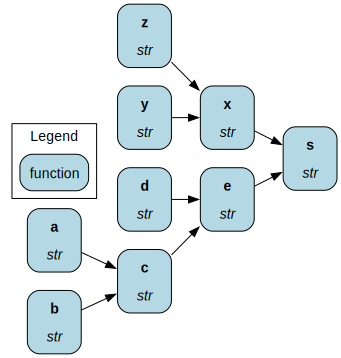

In [2]:
%%cell_to_module my_functions --display

import time


def a() -> str:
    print("a")
    time.sleep(3)
    return "a"


def b() -> str:
    print("b")
    time.sleep(3)
    return "b"


def c(a: str, b: str) -> str:
    print("c")
    time.sleep(3)
    return a + " " + b


def d() -> str:
    print("d")
    time.sleep(3)
    return "d"


def e(c: str, d: str) -> str:
    print("e")
    time.sleep(3)
    return c + " " + d


def z() -> str:
    print("z")
    time.sleep(3)
    return "z"


def y() -> str:
    print("y")
    time.sleep(3)
    return "y"


def x(z: str, y: str) -> str:
    print("x")
    time.sleep(3)
    return z + " " + y


def s(x: str, e: str) -> str:
    print("s")
    time.sleep(3)
    return x + " " + e



# Run it without the adapter

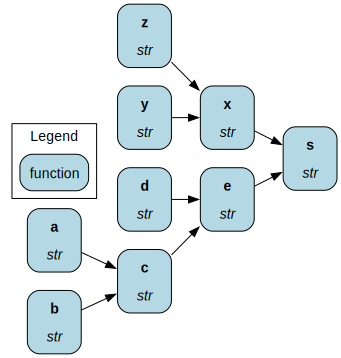

In [6]:
from hamilton import driver
dr = driver.Builder().with_modules(my_functions).build()
dr

In [7]:
start = time.time()
r = dr.execute(["s", "x", "a"])
print("got return from dr")
print(r)
print("Time taken with", time.time() - start)

z
y
x
a
b
c
d
e
s
got return from dr
{'s': 'z y a b d', 'x': 'z y', 'a': 'a'}
Time taken with 27.080925941467285


# Run it with the adapter -- note the parallelism & time taken

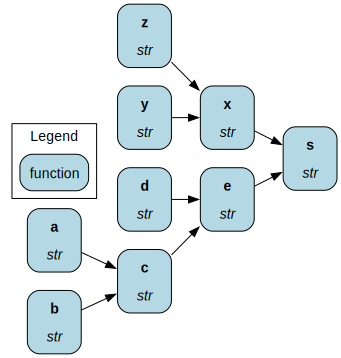

In [8]:
from hamilton import driver
from hamilton.plugins import h_threadpool

adapter = h_threadpool.FutureAdapter()
dr = driver.Builder().with_modules(my_functions).with_adapters(adapter).build()
dr

In [9]:
start = time.time()
r = dr.execute(["s", "x", "a"])
print("got return from dr")
print(r)
print("Time taken with", time.time() - start)

z
y
a
b
d
x
c
e
s
got return from dr
{'s': 'z y a b d', 'x': 'z y', 'a': 'a'}
Time taken with 12.019250869750977


# 27 seconds vs 12 seconds

With the adapter we see a significant improvement in time taken to execute the DAG. This is because the adapter is able to parallelize the execution.